<a href="https://colab.research.google.com/github/simodepth/Redirect-Matching/blob/main/Redirect_Matching_with_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Redirect Matching with NLP: find out the best URLs to redirect 404 and 3xx pages



##Requirements and Assumptions
- Ahrefs export of:
  - URLs "**best by links**" from Ahrefs > You can choose whether to filter the results by 404, 301 and so on. 
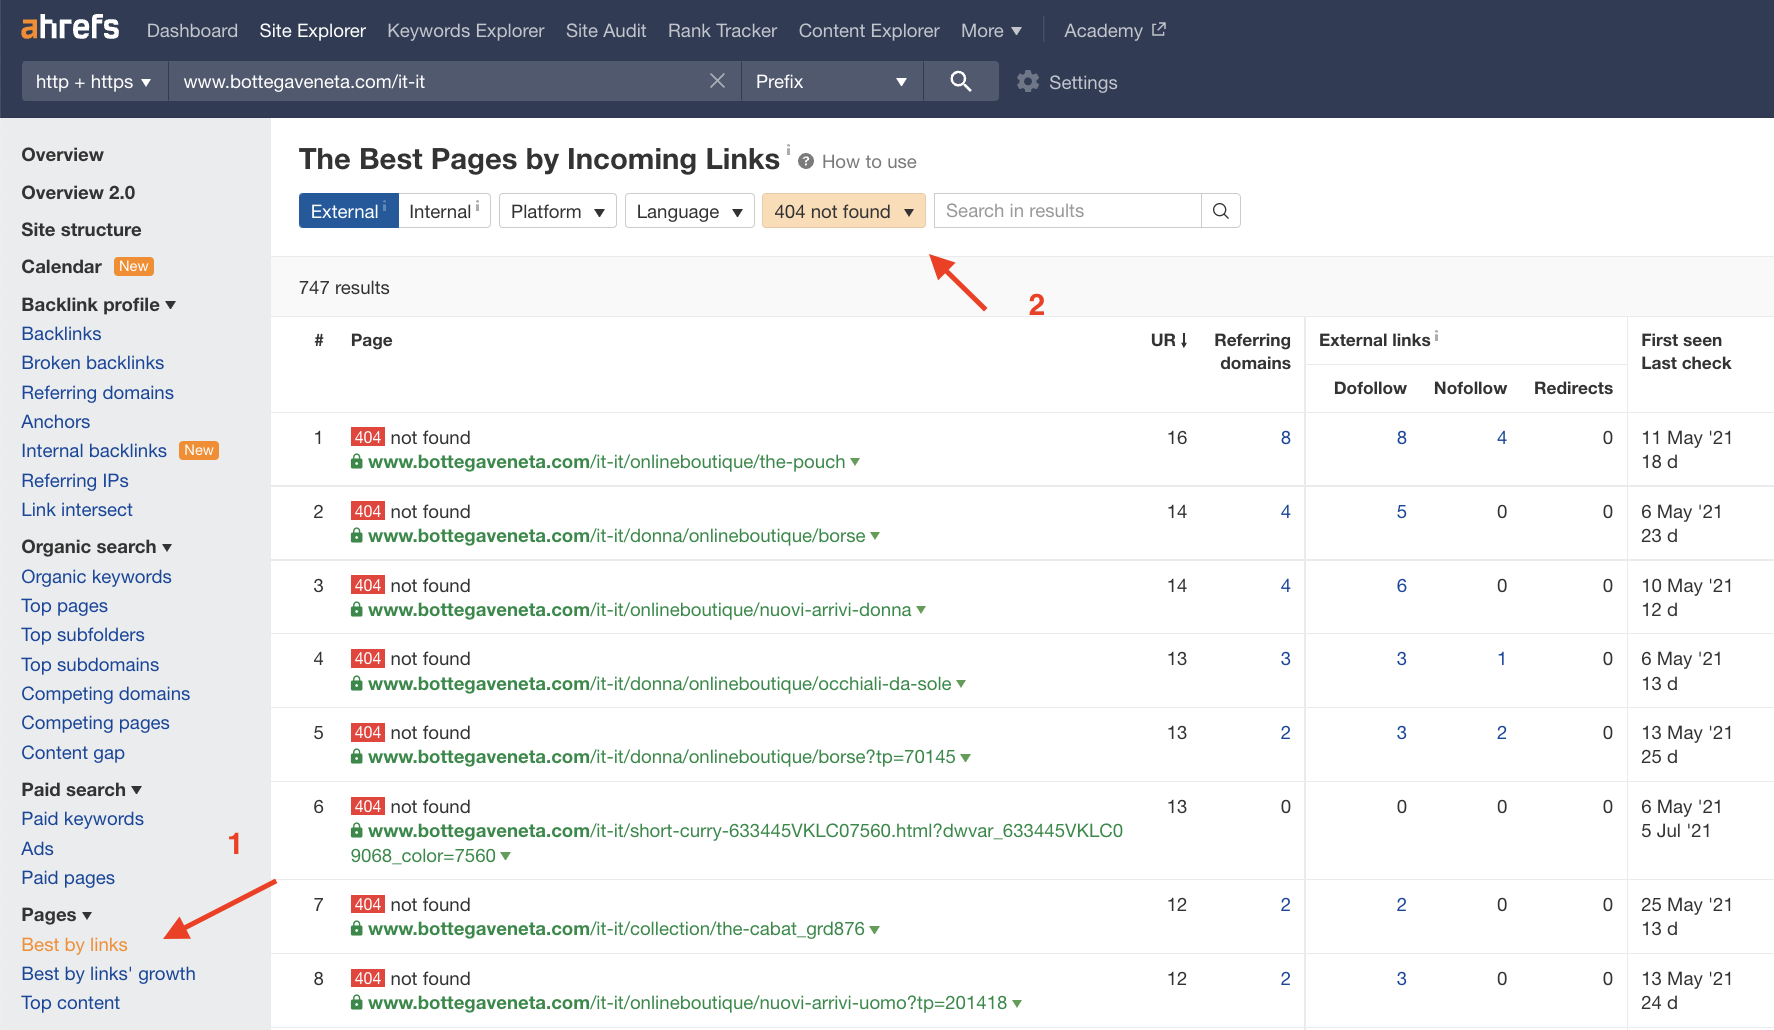

  - Export XLSX file of "**Top Pages**" in Ahrefs
  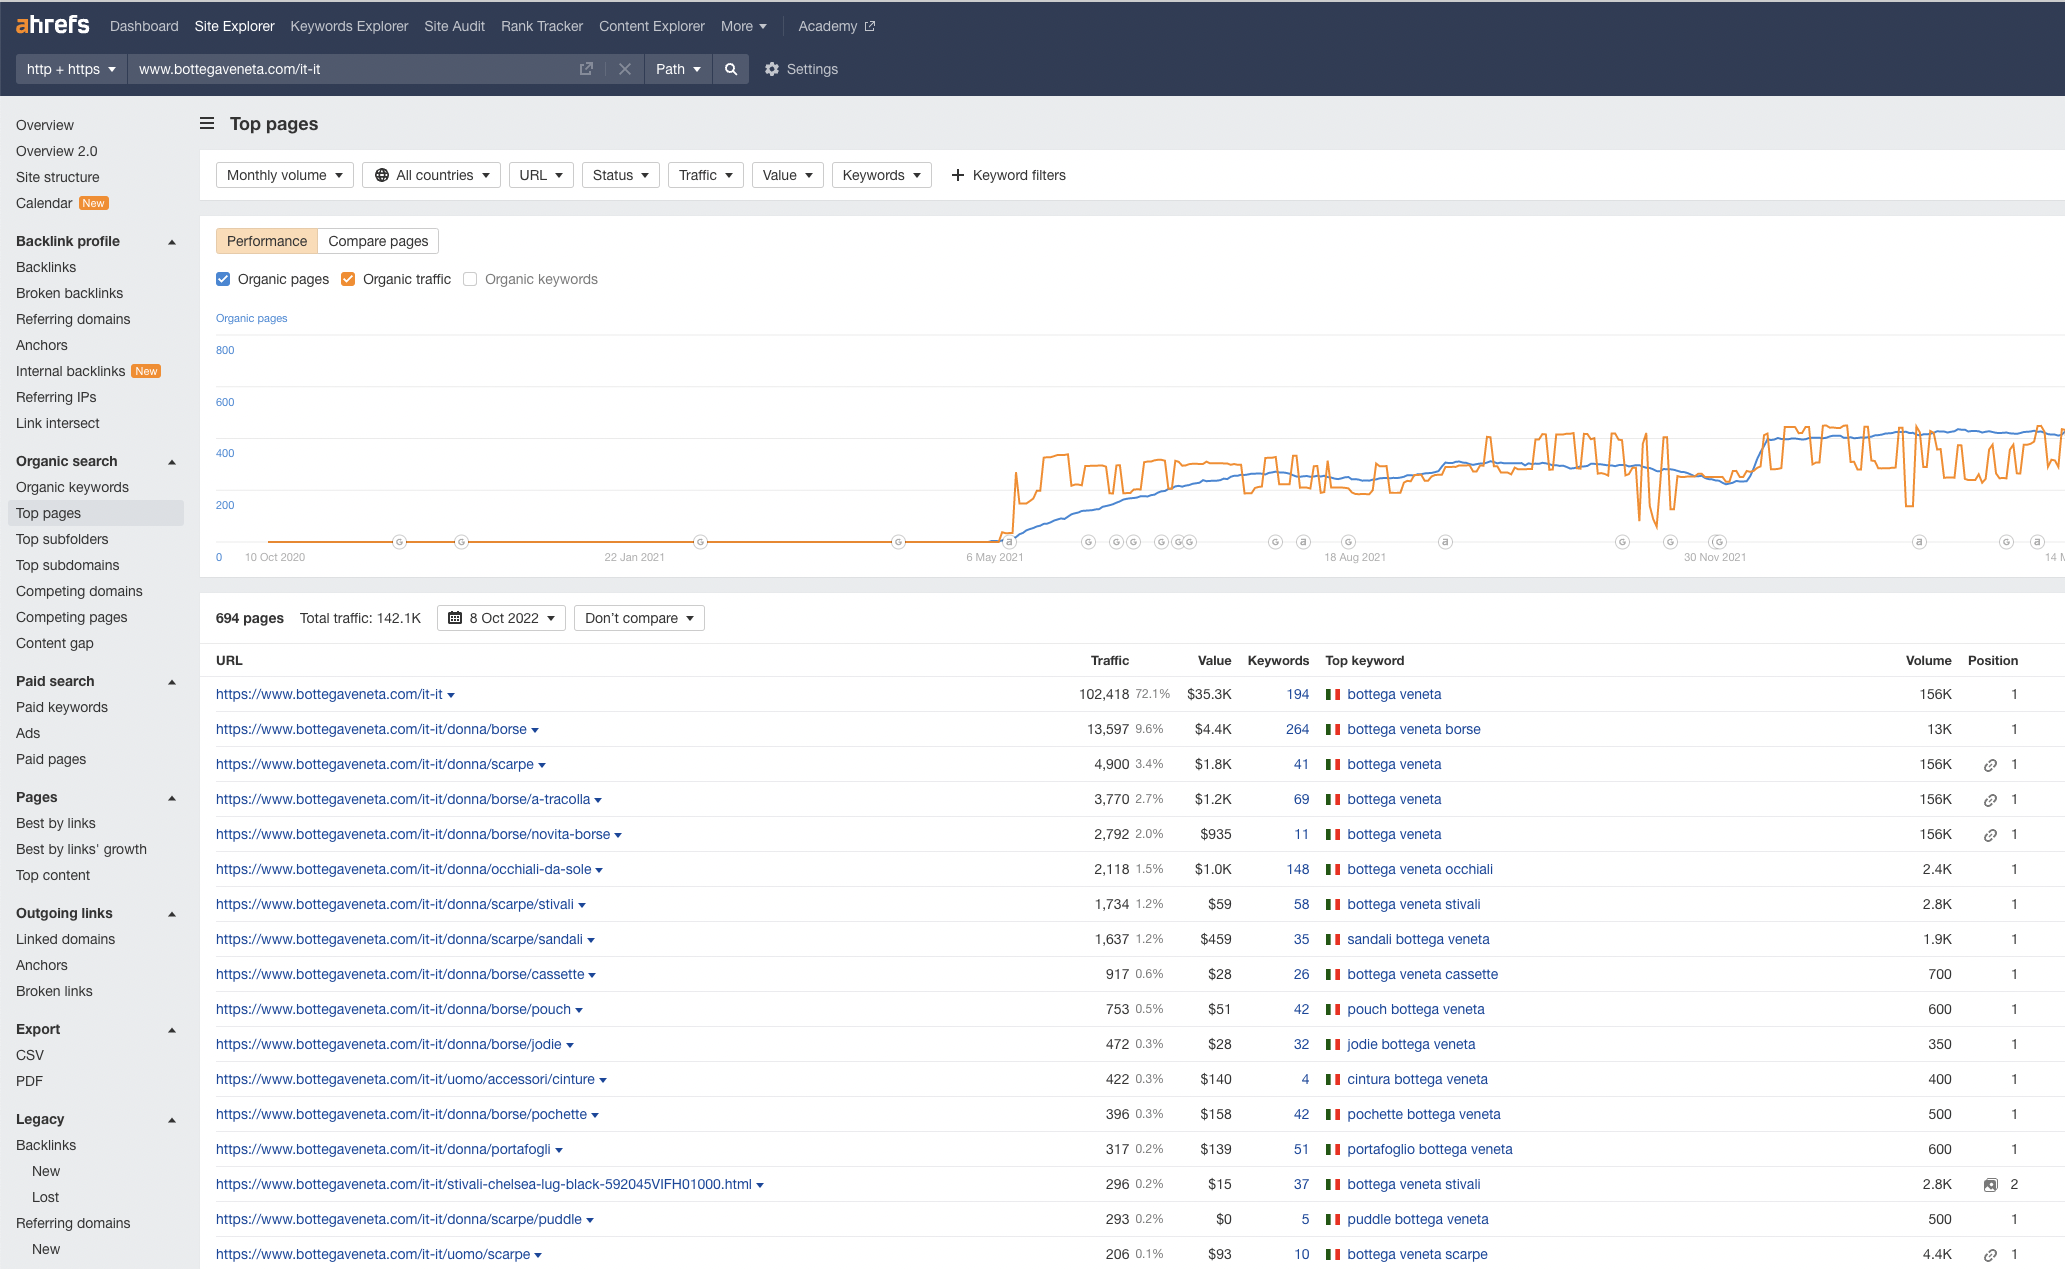




##Before Running the Script


---


Once you export the XLSX dataset, make sure to manually remove useless columns (e.g country lang).

**IMPORTANT** = make sure to have the **first columns** of both the exported reports set as follows:
- The Broken(or redirect) report: **"Page URL"**
- The Top Pages report: "**URL**"





#1) Export **Best By Links** (Broken or Redirect Pages)


---


These are your pages that are currently broken that have links to them, the ones you want to redirect and find relevant redirect targets for.

Keep only the number of **best by links** pages with **referring domain** to avoid overloading the script to no use. You can sort the dataframe as you wish (e.g by UR, by referring domains, by links).

- If you look for 404 pages that have links pointing to them, you could find the best match to plan a redirect mapping
- If you look for 3xx that have links pointing to them, you could use the redirected pages to look for better matches

In [26]:
import pandas as pd

Page_URL = pd.read_excel('/content/www.bottegaveneta.xlsx')
broken = pd.DataFrame(Page_URL, columns=['Page URL'])
broken.head()

,Page URL
0,https://www.bottegaveneta.com/it-it/onlinebout...
1,https://www.bottegaveneta.com/it-it/donna/onli...
2,https://www.bottegaveneta.com/it-it/onlinebout...
3,https://www.bottegaveneta.com/it-it/donna/onli...
4,https://www.bottegaveneta.com/it-it/collection...


#2)Export **Top Pages** (Current pages by Traffic)

These are pages that receive the highest proportion of traffic.
Again, try to keep the number of the export cases as lower as possible to not override the script. 

To exclude the highest number of stats outliers from this script, we want to run a similarity score between 2 equivalent datasets.

Depending on the number of Broken/redirect pages with referring domains pointing at them, you can inform your decision-making in selecting the best number of current ranking pages within this export.

**(e.g best by links URL = 30, Top pages URL = 30)**





In [13]:
Top_Pages = pd.read_excel('/content/top pages BVG.xlsx')
df2 = pd.DataFrame(Top_Pages, columns=['URL'])
df2.head()

,URL
0,https://www.bottegaveneta.com/it-it
1,https://www.bottegaveneta.com/it-it/donna/borse
2,https://www.bottegaveneta.com/it-it/donna/scarpe
3,https://www.bottegaveneta.com/it-it/donna/bors...
4,https://www.bottegaveneta.com/it-it/donna/bors...


## Needed Installs and Libraries

just push play on each

In [7]:
!python -m spacy download en_core_web_lg
!apt update
!apt install chromium-chromedriver
!pip install selenium==3.141.0

2022-10-08 08:14:48.198316: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.1 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates

In [8]:
import io
import csv
import time
import requests
import re
import warnings
warnings.simplefilter("ignore", UserWarning)
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load(disable=['parser', 'tagger', 'ner'])

# Scrape the archives of broken URLs

This part digs deep in the web archives to check whether each 404s/3xx exists in archive.org. If so it grabs the most recent snapshot.


---



N.B:

*make sure to for loop `broken` as it is the dataframe from the 1) Export

*may need a process to check if the page is still broken. Some false positives where pages still exist have appeared in testing.

*may need to add filter for paths or do something to solve for multiple versions in different countries





In [14]:
archive_urls = []
for row in broken.itertuples():
    url = row[1]
    r = requests.get("https://archive.org/wayback/available?url=" + url)
    try:
         archive_urls.append(r.json()['archived_snapshots']['closest']['url'])
         time.sleep(0.2)
    except requests.exceptions.HTTPError as errh:
        print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)
    except requests.exceptions.RequestException as err:
        print ("Oops: Something Else",err)
    except KeyError:
        continue
    except ValueError:
        continue
print (archive_urls)

['http://web.archive.org/web/20220124071929/https://www.bottegaveneta.com/it-it/climber-camping-661253V00P13236.html', 'http://web.archive.org/web/20210831132503/https://www.bottegaveneta.com/it-it/lido-ice-608854VBSS04759.html', 'http://web.archive.org/web/20220424205059/https://www.bottegaveneta.com/it-it/mini-jodie-kiwi-651876VCPP53520.html']


## Extract body text of archive URLs

Loads headless chrome and grabs content of the pages from archive.org. 

In [15]:
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
caps = DesiredCapabilities().CHROME
caps["pageLoadStrategy"] = "eager"
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--incognito')
options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',options=options)
wd.maximize_window()
wd.set_page_load_timeout(30)

archive_text = []
for x in archive_urls:
    try:
        wd.get(url=x)
        body_text = wd.find_element_by_tag_name("body").text
        archive_text.append({'archive_url': x, 'archive_text': body_text})
        time.sleep(10)
    except requests.exceptions.HTTPError as errh:
        print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)
    except requests.exceptions.RequestException as err:
        print ("Oops: Something Else",err)
    except TimeoutException as ex:
        print ("TimeoutException",ex)
archive = pd.DataFrame.from_dict(archive_text)
archive.head()

,archive_url,archive_text
0,http://web.archive.org/web/20220124071929/http...,Vai al contenuto principale\nMenu\nMENU\n\nHom...
1,http://web.archive.org/web/20210831132503/http...,Vai al contenuto principale\nAcquista in: Ital...
2,http://web.archive.org/web/20220424205059/http...,Vai al contenuto principale\nAcquista in: Ital...


# Scrape body text of current URLs

Loads headless chrome and grabs content of the pages from archive.org. 


In [17]:
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
caps = DesiredCapabilities().CHROME
caps["pageLoadStrategy"] = "eager"
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--incognito')
options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',options=options)
wd.maximize_window()
wd.set_page_load_timeout(20)

current_text = []
for row in df2.itertuples():
    url = row[1]
    try:
        wd.get(url)
        body_text = wd.find_element_by_tag_name("body").text
        current_text.append({'current_url': url, 'current_text': body_text})
        time.sleep(2)
    except requests.exceptions.HTTPError as errh:
        print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)
    except requests.exceptions.RequestException as err:
        print ("Oops: Something Else",err)
    except TimeoutException as ex:
        print ("TimeoutException",ex)
current = pd.DataFrame.from_dict(current_text)
current.head()


,current_url,current_text
0,https://www.bottegaveneta.com/it-it,Vai al contenuto principale\nMenu\nMenu\n\nCer...
1,https://www.bottegaveneta.com/it-it/donna/borse,Vai al contenuto principale\nMenu\nMenu\n\nCer...
2,https://www.bottegaveneta.com/it-it/donna/scarpe,Vai al contenuto principale\nMenu\nMenu\n\nCer...
3,https://www.bottegaveneta.com/it-it/donna/bors...,Vai al contenuto principale\nMenu\nMenu\n\nCer...
4,https://www.bottegaveneta.com/it-it/donna/bors...,Vai al contenuto principale\nMenu\nMenu\n\nCer...


#Data Preprocessing

Now we have:
- The Archived URLs with their body text
- The Current URLs with their current body text

Before inspecting similarities, we need to remove things like stop words and punctuation, text lemmatization to make the process smoother and faster.

In [19]:
stops = spacy.lang.en.stop_words.STOP_WORDS
import string
punctuations = string.punctuation

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops and lemma not in punctuations):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

archive['archive_nlp'] = archive['archive_text'].apply(normalize, lowercase=True, remove_stopwords=True)
current['current_nlp'] = current['current_text'].apply(normalize, lowercase=True, remove_stopwords=True)


# The matching function: How Similar is **Content** from Old vs Current URL

Next up, this is looking at the content of the old URLs and checking how similar it is to each page on the current site.

In [20]:
matching = []
for index, archive_row in archive.iterrows():
    for index, current_row in current.iterrows(): 
        similarity = nlp(archive_row['archive_nlp']).similarity(nlp(current_row['current_nlp']))
        matching.append({'archive_url': archive_row['archive_url'], 'current_url': current_row['current_url'], 'similarity': similarity })

## Archive.org Data Cleaning + Pandas Dataframe 

This is to give you the old URLs again. It cleans the archive.org URL

In [21]:
for x in matching:
    x.update({'old_url': re.sub(':80', '', re.sub('http:\/\/web\.archive\.org\/web\/[0-9]*\/', '', x['archive_url']))})
matching_pd = pd.DataFrame.from_dict(matching)

matching_pd.drop(['archive_url'], inplace=True, axis=1)
matching_pd.drop(matching_pd[matching_pd.similarity > 1].index, inplace=True)

matching_pd.head()



,current_url,similarity,old_url
0,https://www.bottegaveneta.com/it-it,0.676389,https://www.bottegaveneta.com/it-it/climber-ca...
1,https://www.bottegaveneta.com/it-it/donna/borse,0.498494,https://www.bottegaveneta.com/it-it/climber-ca...
2,https://www.bottegaveneta.com/it-it/donna/scarpe,0.417328,https://www.bottegaveneta.com/it-it/climber-ca...
3,https://www.bottegaveneta.com/it-it/donna/bors...,0.499728,https://www.bottegaveneta.com/it-it/climber-ca...
4,https://www.bottegaveneta.com/it-it/donna/bors...,0.518290,https://www.bottegaveneta.com/it-it/climber-ca...


In [28]:
#@title Sort the Output for the better
matching_pd.reset_index().sort_values(['similarity', 'old_url'], ascending=False).set_index(['old_url','current_url']).groupby('old_url').head()

index  \
old_url                                            current_url                                                 
https://www.bottegaveneta.com/it-it/climber-cam... https://www.bottegaveneta.com/it-it/stivaletti-...     25   
https://www.bottegaveneta.com/it-it/lido-ice-60... https://www.bottegaveneta.com/it-it                    29   
https://www.bottegaveneta.com/it-it/mini-jodie-... https://www.bottegaveneta.com/it-it                    58   
https://www.bottegaveneta.com/it-it/climber-cam... https://www.bottegaveneta.com/it-it/stivali-che...     14   
https://www.bottegaveneta.com/it-it/mini-jodie-... https://www.bottegaveneta.com/it-it/chain-pouch...     81   
                                                   https://www.bottegaveneta.com/it-it/uomo/portaf...     80   
                                                   https://www.bottegaveneta.com/it-it/stivaletti-...     83   
https://www.bottegaveneta.com/it-it/lido-ice-60... https://www.bottegaveneta.com/it-it/uomo/portaf...     51   
https://www.bottegaveneta.com/it-it/mini-jodie-... https://www.bottegaveneta.com/it-it/stivali-che...     72   
https://www.bottegaveneta.com/it-it/climber-cam... https://www.bottegaveneta.com/it-it/chain-pouch...     23   
https://www.bottegaveneta.com/it-it/lido-ice-60... https://www.bottegaveneta.com/it-it/chain-pouch...     52   
                                                   https://www.bottegaveneta.com/it-it/stivaletti-...     54   
https://www.bottegaveneta.com/it-it/climber-cam... https://www.bottegaveneta.com/it-it/padded-cass...     17   
                                                   https://www.bottegaveneta.com/it-it/mini-pouch-...     26   
https://www.bottegaveneta.com/it-it/lido-ice-60... https://www.bottegaveneta.com/it-it/stivali-che...     43   

                                                                                                       similarity  
old_url                                            current_url                                                     
https://www.bottegaveneta.com/it-it/climber-cam... https://www.bottegaveneta.com/it-it/stivaletti-...    0.911781  
https://www.bottegaveneta.com/it-it/lido-ice-60... https://www.bottegaveneta.com/it-it                   0.909516  
https://www.bottegaveneta.com/it-it/mini-jodie-... https://www.bottegaveneta.com/it-it                   0.888784  
https://www.bottegaveneta.com/it-it/climber-cam... https://www.bottegaveneta.com/it-it/stivali-che...    0.885703  
https://www.bottegaveneta.com/it-it/mini-jodie-... https://www.bottegaveneta.com/it-it/chain-pouch...    0.787005  
                                                   https://www.bottegaveneta.com/it-it/uomo/portaf...    0.782532  
                                                   https://www.bottegaveneta.com/it-it/stivaletti-...    0.780984  
https://www.bottegaveneta.com/it-it/lido-ice-60... https://www.bottegaveneta.com/it-it/uomo/portaf...    0.773925  
https://www.bottegaveneta.com/it-it/mini-jodie-... https://www.bottegaveneta.com/it-it/stivali-che...    0.758037  
https://www.bottegaveneta.com/it-it/climber-cam... https://www.bottegaveneta.com/it-it/chain-pouch...    0.756697  
https://www.bottegaveneta.com/it-it/lido-ice-60... https://www.bottegaveneta.com/it-it/chain-pouch...    0.753461  
                                                   https://www.bottegaveneta.com/it-it/stivaletti-...    0.751483  
https://www.bottegaveneta.com/it-it/climber-cam... https://www.bottegaveneta.com/it-it/padded-cass...    0.728422  
                                                   https://www.bottegaveneta.com/it-it/mini-pouch-...    0.717371  
https://www.bottegaveneta.com/it-it/lido-ice-60... https://www.bottegaveneta.com/it-it/stivali-che...    0.714582

Let's take the first similarity example:
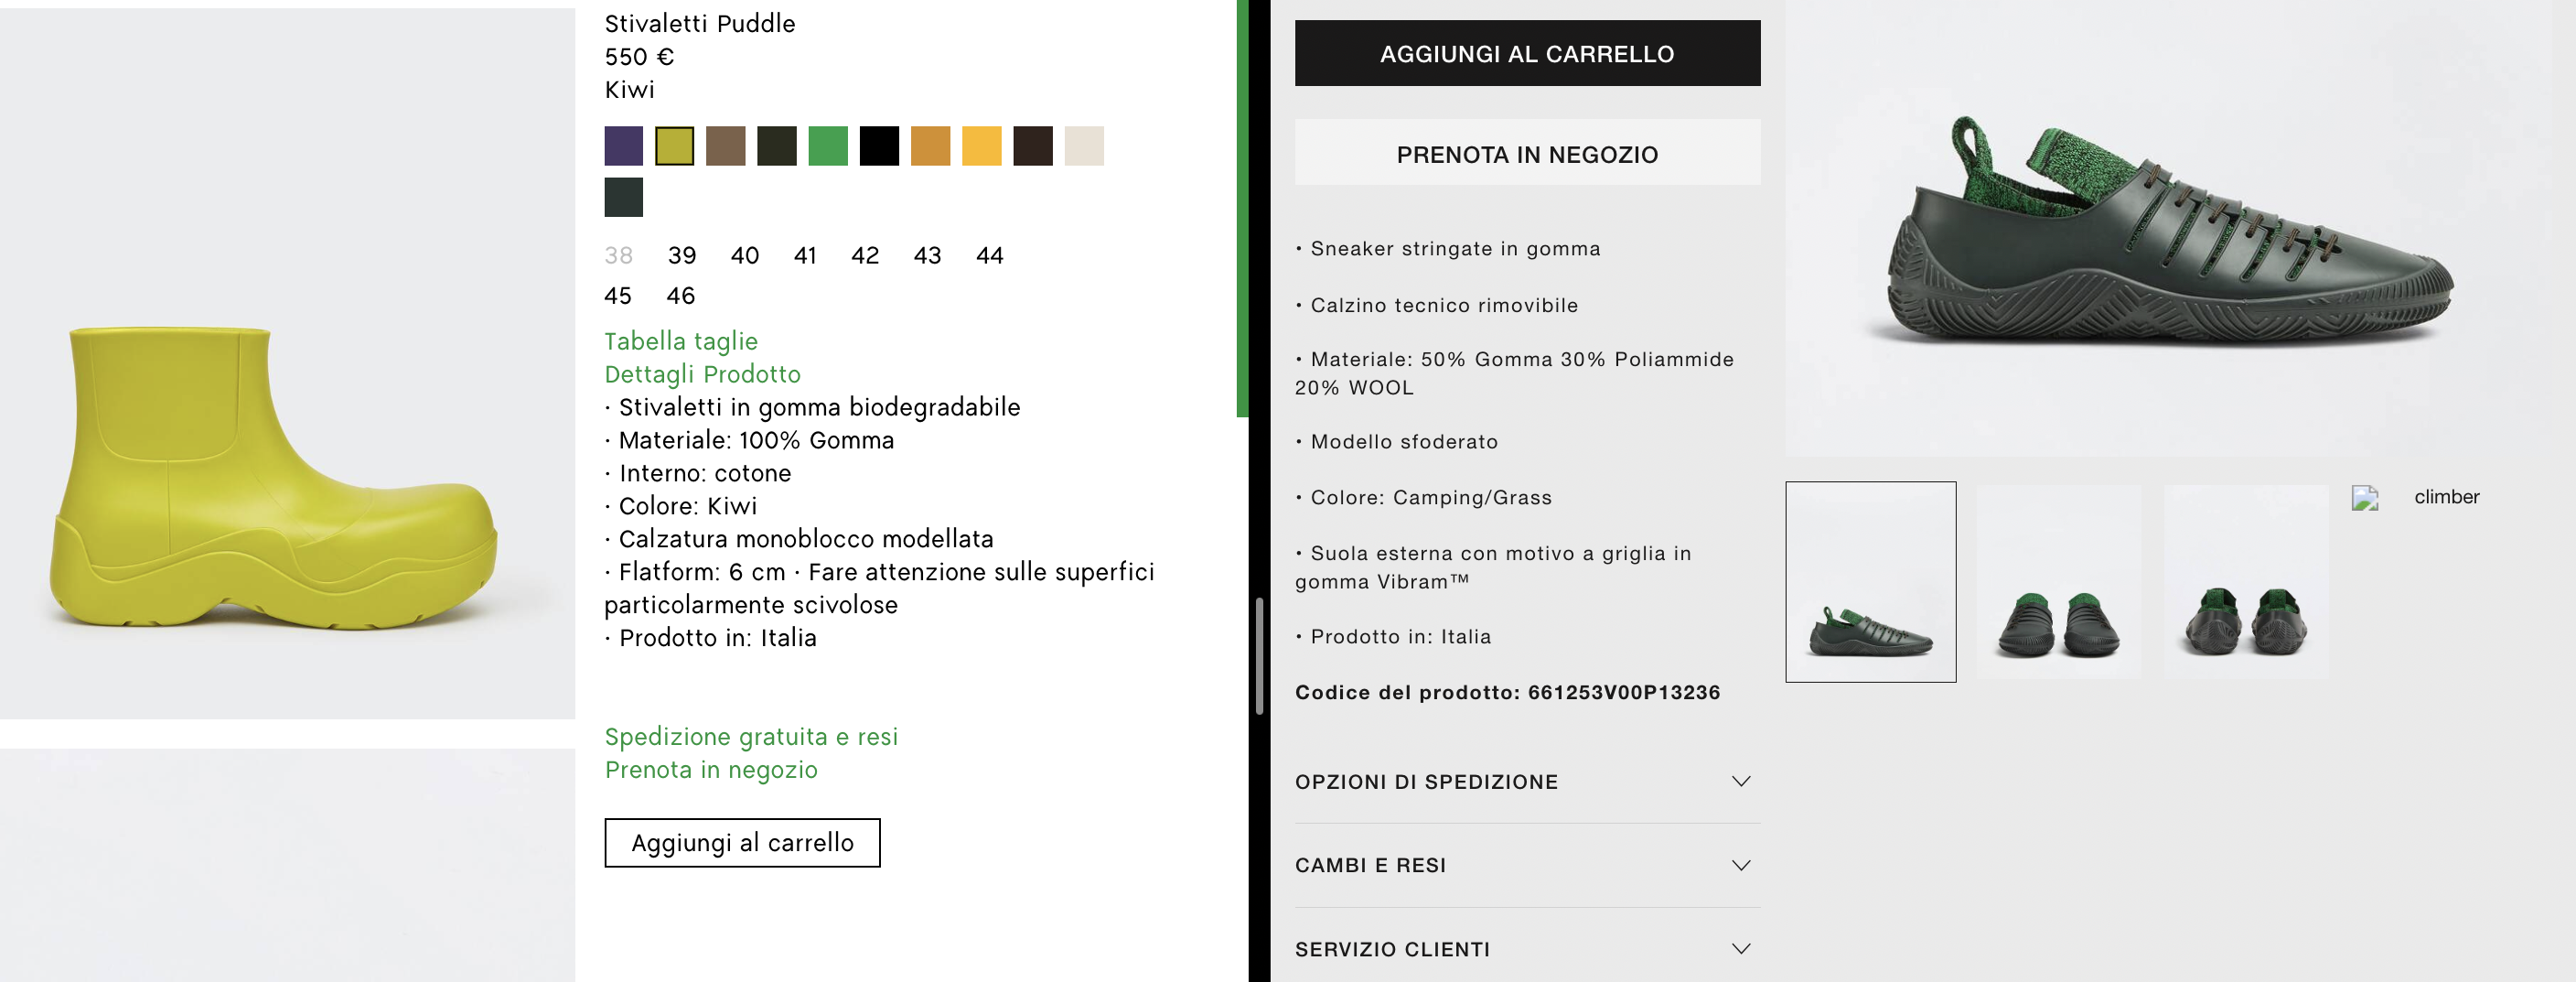


We can confirm there is a factual degree of similarity between the **current page** (left) and the **old page** (right), as estimated by the NLP machine learning model.

Hence, this old page might be eligible for a redirect to the shortlisted current page instead of being left floated around as 404.

N.B: in general 404 pages do not harm your internal linking structure and the website's SEO. It depends on the case scenario.

## Save the file

Cleaning the data. Insert table. Sort by Similarity descending. Remove duplicates from old_url.

In [27]:
from google.colab import files
matching_pd.to_csv('matching.csv') 
files.download('matching.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>